# Photon Signal Rate Plots

This notebook outputs the reach plots in $\varepsilon - m_A$ space for IceCube.

Upon running this notebook the first time, run each cell sequentially. If however, you have started a calculation and now wish to continue where you left off, begin at the "External File Interpolations" cell and continue onward.

## Import Notebook as module

In [1]:
import io, os, sys, types

from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell

def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path

    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        if os.path.isfile(nb_path):
            return nb_path
        
class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path

    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)

        print ("importing Jupyter notebook from %s" % path)

        # load the notebook object
        with io.open(path, 'r', encoding='utf-8') as f:
            nb = read(f, 4)


        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod

        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__

        try:
            for cell in nb.cells:
                if cell.cell_type == 'code':
                    # transform the input to executable Python
                    code = self.shell.input_transformer_manager.transform_cell(cell.source)
                    # run the code in themodule
                    exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod

    
class NotebookFinder(object):
    """Module finder that locates Jupyter Notebooks"""
    def __init__(self):
        self.loaders = {}

    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return

        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)

        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]
    
sys.meta_path.append(NotebookFinder())

print ('Complete')

Complete


In [2]:
from MasterFunctions_SignalRates import *
from MasterFunctions_Graphing import*

print ('All Notebooks Imported')

importing Jupyter notebook from MasterFunctions_SignalRates.ipynb
importing Jupyter notebook from MasterFunctions_Capture.ipynb
importing Jupyter notebook from MasterFunctions_ModelData.ipynb
------ MasterFunctions_ModelData Imported ------
------ MasterFunctions_Capture Loaded ------
importing Jupyter notebook from MasterFunctions_Annihilation.ipynb
------ MasterFunctions_Annihilation Loaded ------
------ MasterFunctions_SignalRates Imported ------
importing Jupyter notebook from MasterFunctions_Graphing.ipynb
------ MasterFunctions_Graphing Loaded ------
All Notebooks Imported


# Signal Rate


Recall the solution to the differential equation:
\begin{equation}
\frac{dN_X}{dt} = C_{cap} - N_X^2 C_{ann}
\end{equation}

is given by:

\begin{equation}
\Gamma_{ann} = \frac{1}{2} C_{cap}\tanh^2 \left( \frac{\tau_{\oplus}}{\tau} \right)
\end{equation}

more stuff about the signal rate

-------------

# Generating the Signal Data File

## Recipie

The recipie for generating the Signal File is:
    
1). Generate a Template Dataframe

2). Write that Dataframe to an external .csv file

3). Read in and interpolate the Branching Ratio for a given process and the Sommerfeld enhancement

4). Calculate $C_{Cap}$, $C_{Ann}$, $\Gamma_{Ann}$, and $N_{Sig}$ and append them to the signal .csv file.

Step four can be quite lengthy depending on the desired resultioin on the data points. Typically, one would begin these calculations and be forced to wait until they are completed in their entirety; perhaps unable to shut down their machine for hours at a time. The cell "Signal File Calculations" however can be interrupted at any time, and resumed later. This allows the user to run the calculation in multiple stages instead of dedicating a large chunk of time and running the calculation all at once. 
The calculation can be stopped by interrupting the Jupyter Kernel. Be sure to run the "Manual Overwrite" cell just to be sure that the calculations are saved.

## Initialize External Signal File

### Define the Resolution of the Signal Plot

These cells create the "grid" of data points for which $N_{sig}$ will be calculated.

This cell initializes the resolution of the reach plot. $\texttt{num}$ defines the resolution of the grid, so if $\texttt{num} = 50$, the reach plot will have a $50 \times 50$ resolution for a total of 2500 calculations. The suggested resolution is 

    num = 200
    
 It is important that this number is large enough to capture an accurate interpolation for the Sommerfeld enhancements.

In [76]:
# num = 200
num = 75

print ('Complete')

Complete


## External File Interpolations

The following cells read in and create interpolations of the:

1). Sommerfeld Enhancement

2). Branching ratio

The branching ratio data is stored in a folder called "BranchingRatioData."

The Sommerfeld data, which has been calculated prior, is stored in the folder "Sommerfeld Data."

### Sommerfeld Data Interpolation

The following two cells read in an external Sommerfeld data file and:

1). Append the m_X value defined in the Sommerfeld file to the Signal file

2). Append the Kappa0 value defined in the Sommerfeld file to the Signal File

3). Interpolate the discrete set of ($m_A$, $\langle S_s \rangle$) points into a continuous function $\langle S_s \rangle(m_A)$

The resolution defined above in $\texttt{num}$ defines the resolution of the Sommerfeld interpolation. Depending on the specified values of $m_X$, the resolution may need to be increased to capture an accurate interpolation.  

### Visualization of Sommerfeld Resolution

The following cell plots the sommerfeld enhancement given the number of data points for a single axis of the signal file. If a greater number of data points is required, under the "Initialize Data Ranges" cell, change the "num" parameter, and run the notebook to this point again.

Sommerfeld File: testSommerfeld.csv
Sommerfeld interpolation complete
Complete


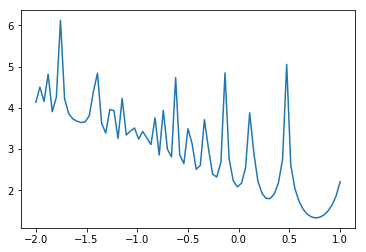

In [77]:
####################################
# Define Sommerfeld and Signal Files
####################################
SommName = input('Sommerfeld File: ')
SommFile = pd.read_csv(photonSommerfeldPath(SommName))

####################################
# Interpolate Sommerfeld data
####################################
mAData = SommFile['mA[GeV]']
SommData = SommFile['ThermAvgSommerfeld']
SommInterp = interpolate.interp1d(mAData,SommData)
print ('Sommerfeld interpolation complete')

####################################

####################################
m_XSommerfeld = SommFile.loc[0,'mX[GeV]']
kappa0Sommerfeld = SommFile.loc[0,'Kappa0']


vect1 = []
vect2 = []
for ma in np.logspace(-2,1, num, base = 10):
    vect1.append(ma)
    vect2.append(SommInterp(ma))

    
plt.plot(np.log10(vect1),np.log10(vect2))

print ('Complete')

### Branching Ratio Interpolation

In this cell, we read in a .csv file containing discrete branching ratio data points obtained from WebPlotDigitizer and interpolate them into a continuous funciton named "branchRatioInterp."

brtoeAdam.csv
Complete


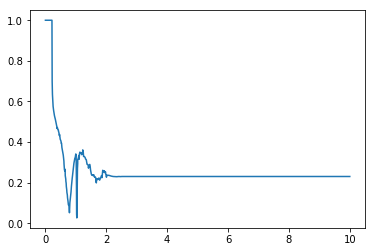

In [78]:
# branchFile = input('Branching File: ')
branchFile = 'brtoeAdam.csv'

BranchData = pd.read_csv(photonBranchPath(branchFile))

print (branchFile)

xList = BranchData['mA[GeV]']
yList = BranchData['BR']

branchRatioInterp = interpolate.interp1d(xList,yList)

plt.plot(xList,yList)

print ('Complete')

## Initialize Signal Data File

### Initialize Dataframe

This cell initializes the data ranges and creates an .csv

In [79]:
#########################################
# Define parameter space Ranges
#########################################
# Logarithmic Spacing
mALogRange = np.logspace(-2, 1, num, base = 10)
epsilonLogRange = np.logspace(-10, -5, num, base = 10)

#########################################
# Initialize Master Arrays
#########################################
masterSignalArray = []

#########################################
# Populate the Master Arrays with the column headers and 'None' Cells
#########################################
counter = 0
for mATemp in mALogRange:
    for epsilonTemp in epsilonLogRange:
        masterSignalArray.append([counter, ' ', mATemp, epsilonTemp, \
                                  'None', 'None', 'None', 'None',' ', ' ',' '])
        counter += 1

#########################################
# Create a PANDAS DataFrame from the Master Arrays
#########################################
masterSignalDataframe = pd.DataFrame(data = masterSignalArray, \
    columns=['Counter', 'mX[GeV]', 'mA[GeV]', 'Epsilon',\
             'Capture', 'Annihilation', 'GammaAnn', 'IceCubeSignal', 'BranchingRatioFile','Resolution','Kappa0'])

# filename = input('Signal Rate Filename: ')
# writeFile = photonSignalDataPath(filename)
# masterSignalDataframe.to_csv(writeFile, index=False)

print ('Complete')

Complete


### Write to External .csv File

This cell writes the dataframe to a csv

In [80]:
SignalFile = input('Signal Rate filename: ')

writeFile = photonSignalDataPath(SignalFile)

# Append a single value onto the Kappa0 Column
kappa0Value = 'None'
m_XValue = 'None'

# print (branchFile)

masterSignalDataframe.set_value(0, 'mX[GeV]', m_XSommerfeld)
masterSignalDataframe.set_value(0, 'Kappa0' , kappa0Sommerfeld)
masterSignalDataframe.set_value(0, 'BranchingRatioFile', branchFile)
masterSignalDataframe.set_value(0, 'Resolution', num)

masterSignalDataframe.to_csv(writeFile, index=False)

print ('Complete')

Signal Rate filename: testSignal.csv
Complete


### Copy over Sommerfeld Parameters

This cell copies over the parameters defined in the Sommerfeld file (mX and Kappa0) to the Signal Datafile


In [81]:
####################################
# Define Sommerfeld and Signal Files
####################################
# SommName = input('Sommerfeld File: ')
# SommFile = pd.read_csv(photonSommerfeldPath(SommName))
# filename = input('Signal Rate File: ')
# writeFile = photonSignalDataPath(filename)
# dataFrame = pd.read_csv(writeFile , sep = ',')

# print ('')

####################################
# Append Sommerfeld data
####################################
testm_X = dataFrame.loc[0,'mX[GeV]']
testKappa0 = dataFrame.loc[0, 'Kappa0']

if (testm_X == 'None'):
    SommM_X = float(SommFile.loc[0,'mX[GeV]'])
    dataFrame.set_value(0, 'mX[GeV]', SommM_X)

elif(testm_X != 'None'):
    print ('mX value already appended to Signal File')
    
if (testKappa0 == 'None'):
    SommKappa0 = float(SommFile.loc[0,'Kappa0'])
    dataFrame.set_value(0, 'Kappa0', SommKappa0)

elif (testKappa0 != 'None'):
    print ('Kappa0 value already appended to Signal File')

dataFrame.to_csv(writeFile, index=False)


####################################
# Interpolate Sommerfeld data
# ####################################
# mAData = SommFile['mA[GeV]']
# SommData = SommFile['ThermAvgSommerfeld']
# SommInterp = interpolate.interp1d(mAData,SommData)
# print ('Sommerfeld interpolation complete')


print ('Complete')

NameError: name 'dataFrame' is not defined

## Sanity Check

We expect that:

1). The $m_X$ value from the Sommerfeld file is appended to the Signal file

2). The Kappa0 value from the Sommerfeld file is appended to the Signal file

3). The Signal file has 8 columns labeled
    
    Counter, mX[GeV], mA[GeV], Epsilon, Capture, Annihilation, GammaAnn, IceCubeSignal, BranchingRatioFile, Kappa0

In [82]:
filename = input('Signal Rate filename: ')
writeFile = photonSignalDataPath(filename)

print (pd.read_csv(writeFile, sep = ','))
print ('Complete')

Signal Rate filename: testSignal.csv
      Counter mX[GeV]  mA[GeV]       Epsilon Capture Annihilation GammaAnn  \
0           0   750.0     0.01  1.000000e-10    None         None     None   
1           1             0.01  1.168335e-10    None         None     None   
2           2             0.01  1.365008e-10    None         None     None   
3           3             0.01  1.594787e-10    None         None     None   
4           4             0.01  1.863246e-10    None         None     None   
5           5             0.01  2.176897e-10    None         None     None   
6           6             0.01  2.543346e-10    None         None     None   
7           7             0.01  2.971481e-10    None         None     None   
8           8             0.01  3.471687e-10    None         None     None   
9           9             0.01  4.056095e-10    None         None     None   
10         10             0.01  4.738880e-10    None         None     None   
11         11             0

## Signal File Calculations

This cell scans through all the lines of the .csv file and calculates:

1). Capture

2). Annihilation

3). GammaAnn

4). Signal

As mentioned previously, this cell may be stopped, by interrupting the kernel, at any time and resumed later.

In [83]:
fileName = input('Signal Rate filename: ')
writeFile = photonSignalDataPath(fileName)
dataIn = pd.read_csv(writeFile, sep = ',')

#########################################
# Define loop range
#########################################
# Scan down 'Counter' column, start calculating at first non-calculated value
loopRange = range(0,len(dataIn['Counter']))

#########################################
# Parameters independent of data file:
#########################################
Filem_X = float(dataIn.loc[0, 'mX[GeV]'])
FileKappa0 = float(dataIn.loc[0, 'Kappa0'])
Alpha = 1./137
LiveTime = yr2s(10)


#########################################
# Branching Ratio Interpolation
#########################################
interpFile1 = dataIn.loc[0,'BranchingRatioFile']
branchFile1 = pd.read_csv(photonBranchPath(interpFile1))

xList = branchFile1['mA[GeV]']
yList = branchFile1['BR']

branchRatioInterp = interpolate.interp1d(xList,yList)


#########################################
# Begin the loop calculations
#########################################
print (fileName)
print ()
print ('--------------------')
finishedCounter = 0
index = 0
for index in loopRange:
    testValue = dataIn.loc[index, 'IceCubeSignal']
    
    if (testValue == 'None'):
        dataIn.to_csv(writeFile, sep=',',index=False) 

        #########################################
        # Initialize Loop Parameters
        #########################################
        Filem_ATemp = float(dataIn.loc[index, 'mA[GeV]'])
        FileEpsilonTemp = float(dataIn.loc[index, 'Epsilon'])
        Alpha_X = alphaTherm(Filem_X, Filem_ATemp)
        Sommerfeld = SommInterp(Filem_ATemp)
        BranchingRatio = branchRatioInterp(Filem_ATemp)
        
        #########################################
        # Loop Calculations
        #########################################
        Capture = photonCCapQuick(Filem_X, Filem_ATemp, FileEpsilonTemp, Alpha_X, FileKappa0)
        SigmaVTree = photonSigmaVtree(Filem_X, Filem_ATemp, Alpha_X)
        Annihilation = CAnnCalc(Filem_X, SigmaVTree, thermAvgSomm = Sommerfeld)
        GammaAnn = gammaAnn(Capture, Annihilation)
        L = decayLength(Filem_X, Filem_ATemp, FileEpsilonTemp, BranchingRatio)
        EpsilonDecay = epsilonDecay(L)
        
        IceCubeSignal = iceCubeSignal(GammaAnn, EpsilonDecay, LiveTime)
        
        #########################################
        # Append Calculated Values to SignalFile.csv
        #########################################
        dataIn.set_value(index, 'Capture', Capture)
        dataIn.set_value(index, 'Annihilation', Annihilation)
        dataIn.set_value(index, 'GammaAnn', GammaAnn)
        dataIn.set_value(index, 'IceCubeSignal', IceCubeSignal)
        
        
        #########################################
        # Overwrite SignalFile.csv
        #########################################
        dataIn.to_csv(writeFile, sep=',',index=False) 
        finishedCounter += 1
        
        if (index % 20 == 0):
            print ('Calculations for index: {0} recorded'.format(index))
        
    elif (testValue != 'None'):
        finishedCounter += 1
    
    if (finishedCounter == len(dataIn['Counter'])):
        print ('--------------------')
        print ('All Calculations Complete')
        break
        
print ('Complete')

Signal Rate filename: testSignal.csv
testSignal.csv

--------------------
Calculations for index: 0 recorded
Calculations for index: 20 recorded
Calculations for index: 40 recorded
Calculations for index: 60 recorded
Calculations for index: 80 recorded
Calculations for index: 100 recorded
Calculations for index: 120 recorded
Calculations for index: 140 recorded
Calculations for index: 160 recorded
Calculations for index: 180 recorded
Calculations for index: 200 recorded
Calculations for index: 220 recorded
Calculations for index: 240 recorded
Calculations for index: 260 recorded
Calculations for index: 280 recorded
Calculations for index: 300 recorded
Calculations for index: 320 recorded
Calculations for index: 340 recorded
Calculations for index: 360 recorded
Calculations for index: 380 recorded
Calculations for index: 400 recorded
Calculations for index: 420 recorded
Calculations for index: 440 recorded
Calculations for index: 460 recorded
Calculations for index: 480 recorded
Calcula

Calculations for index: 4320 recorded
Calculations for index: 4340 recorded
Calculations for index: 4360 recorded
Calculations for index: 4380 recorded
Calculations for index: 4400 recorded
Calculations for index: 4420 recorded
Calculations for index: 4440 recorded
Calculations for index: 4460 recorded
Calculations for index: 4480 recorded
Calculations for index: 4500 recorded
Calculations for index: 4520 recorded
Calculations for index: 4540 recorded
Calculations for index: 4560 recorded
Calculations for index: 4580 recorded
Calculations for index: 4600 recorded
Calculations for index: 4620 recorded
Calculations for index: 4640 recorded
Calculations for index: 4660 recorded
Calculations for index: 4680 recorded
Calculations for index: 4700 recorded
Calculations for index: 4720 recorded
Calculations for index: 4740 recorded
Calculations for index: 4760 recorded
Calculations for index: 4780 recorded
Calculations for index: 4800 recorded
Calculations for index: 4820 recorded
Calculations

## Manual Overwrite

This cell is a manual overwrite of the sinal file, just for good measure.

In [84]:
dataIn.to_csv(writeFile, sep=',', index=False) 

print ('Complete')

Complete


------------------------

# Generate the Signal Graphs

The general recipie is:

1). Read in a Signal Data file

2). Extract the plot information

3). Plot


## Read in External Signal File

In [85]:
GammaFile = input('Signal Rate filename: ')
readFile = photonSignalDataPath(GammaFile)

print (GammaFile)

Signal Rate filename: testSignal.csv
testSignal.csv


## Define the plot region and extract plot data

We plot the Data under the column

    IceCubeData

In [86]:
rawData = pd.read_csv(photonSignalDataPath(GammaFile))
Filem_X = float(rawData.loc[0,'mX[GeV]'])


#Pull out min / max values

xMin = min(rawData['mA[GeV]'])
xMax = max(rawData['mA[GeV]'])
yMin = min(rawData['Epsilon'])
yMax = max(rawData['Epsilon'])


# Define the dimension of the grid. 
# For an n x n grid, this will pull out the number "n"
# gridDim = len(np.unique(rawData['mA[GeV]']))
gridDim = rawData.loc[0,'Resolution']
print (gridDim)


#########################################
# Create an n x n grid
#########################################
# Logarithmic Spacing
xLogRange = np.logspace(xMin, xMax, gridDim, base = 10)
yLogRange = np.logspace(yMin, yMax, gridDim, base = 10)

xLinRange = np.linspace(xMin, xMax, gridDim)
yLinRange = np.linspace(yMin, yMax, gridDim)

#########################################
# Read in and reshape the Contour data
#########################################
# This reads in contour data as a single column,
#     but we reshape it to a 2D, n x n array to fit the grid

z = [rawData['IceCubeSignal']]
SignalData = np.reshape(z, (len(xLinRange), len(yLinRange)))

print ('Complete')

75
Complete


C:\Users\Adam Green\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: DeprecationWarning: object of type <class 'str'> cannot be safely interpreted as an integer.
C:\Users\Adam Green\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: DeprecationWarning: object of type <class 'str'> cannot be safely interpreted as an integer.


## Plot the Signal Events

C:\Users\Adam Green\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log10


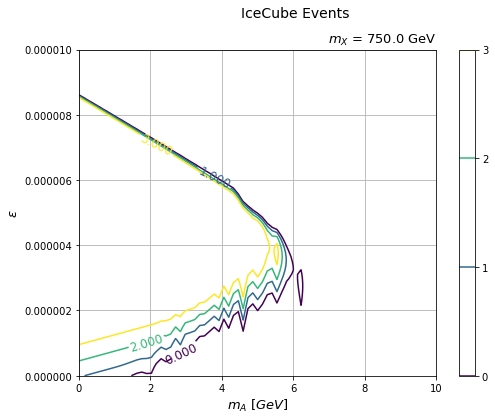

In [87]:
###############################
# Set the correct units for m_X
###############################
m_XUnit = 'None'
if (Filem_X < 1000):
    m_XDisplay = Filem_X
    m_XUnit = 'GeV'

if (Filem_X >= 1000):
    m_XDisplay = Filem_X * 10**-3
    m_XUnit = 'TeV'
    
    
###############################
# Define X,Y tickmarks
###############################
# xTicks = np.linspace(xMin, xMax, 10)
# yTicks = np.linspace(yMin, yMax, 10)
# xTicks = np.logspace((xMin), (xMax), 7, base = 10)
# yTicks = np.logspace(np.log10(yMin),np.log10(yMax),7, base = 10)
    
###############################
# Actual Plotting Stuff
###############################
fig0 = plt.figure(figsize = (8,6))
ax0 = fig0.add_subplot(111)
# ax0.set_xticks(xTicks)
# ax0.set_yticks(yTicks)

CP = plt.contour(np.log10(xLogRange), np.log10(yLogRange), \
                 np.log10(SignalData.transpose()),\
                 levels=[0,1,2,3]
                )


plt.xlabel(r'$m_A$ $[GeV]$', fontsize = 13)
plt.ylabel(r'$\varepsilon$', fontsize = 13)
plt.suptitle('IceCube Events', fontsize = 14)
plt.title(r'$m_X$ = {0} {1}'.format(m_XDisplay, m_XUnit), loc = 'right', fontsize = 13)
# plt.axis([xMin,xMax,yMin,yMax])
plt.clabel(CP, inline=1, fontsize=12)
plt.colorbar()
plt.grid()

### Save Figure

In [48]:
figName = input('Filename: ')

fig0.savefig(photonSignalPlotPath(figName), dpi = 700, bbox_inches = 'tight')
print ('Complete')

Filename: 10TeVSignalPlot.pdf
Complete


C:\Users\Adam Green\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log10


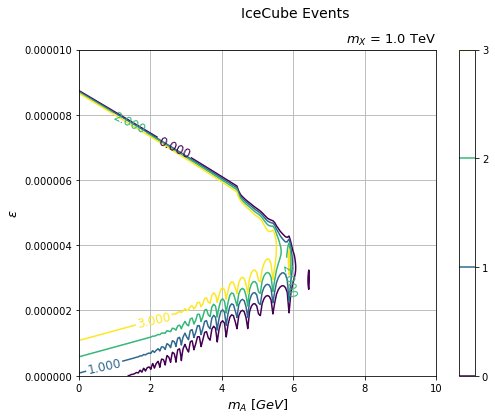

In [32]:
###############################
# Set the correct units for m_X
###############################
m_XUnit = 'None'
if (Filem_X < 1000):
    m_XDisplay = Filem_X
    m_XUnit = 'GeV'

if (Filem_X >= 1000):
    m_XDisplay = Filem_X * 10**-3
    m_XUnit = 'TeV'
    
    
###############################
# Define X,Y tickmarks
###############################
# xTicks = np.linspace(xMin, xMax, 10)
# yTicks = np.linspace(yMin, yMax, 10)
# xTicks = np.logspace((xMin), (xMax), 7, base = 10)
# yTicks = np.logspace(np.log10(yMin),np.log10(yMax),7, base = 10)
    
###############################
# Actual Plotting Stuff
###############################
fig0 = plt.figure(figsize = (8,6))
ax0 = fig0.add_subplot(111)
# ax0.set_xticks(xTicks)
# ax0.set_yticks(yTicks)

CP = plt.contour(np.log10(xLogRange), np.log10(yLogRange), \
                 np.log10(SignalData.transpose()),\
                 levels=[0,1,2,3,],
                )


plt.xlabel(r'$m_A$ $[GeV]$', fontsize = 13)
plt.ylabel(r'$\varepsilon$', fontsize = 13)
plt.suptitle('IceCube Events', fontsize = 14)
plt.title(r'$m_X$ = {0} {1}'.format(m_XDisplay, m_XUnit), loc = 'right', fontsize = 13)
# plt.axis([xMin,xMax,yMin,yMax])
plt.clabel(CP, inline=1, fontsize=12)
plt.colorbar(CP)
plt.grid()

Complete


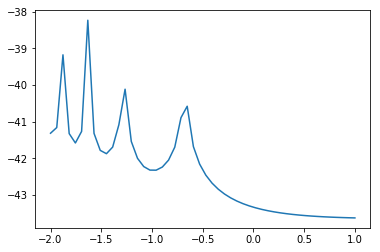

In [21]:
xData = rawData['mA[GeV]']
yData1 = rawData['Annihilation']
yData2 = rawData['Capture']

plt.plot(np.log10(xData),np.log10(yData1))

print ('Complete')

brtoeAdam.csv
       mA[GeV]      BR
0     0.000000  1.0000
1     0.215064  1.0000
2     0.216744  0.8510
3     0.221784  0.6990
4     0.225985  0.6665
5     0.231025  0.6345
6     0.236906  0.6180
7     0.241947  0.6005
8     0.246987  0.5875
9     0.252868  0.5755
10    0.260429  0.5650
11    0.269670  0.5555
12    0.278071  0.5475
13    0.286472  0.5400
14    0.297393  0.5295
15    0.327636  0.5110
16    0.376362  0.4750
17    0.383082  0.4670
18    0.392323  0.4715
19    0.412486  0.4610
20    0.425087  0.4600
21    0.428447  0.4535
22    0.439368  0.4490
23    0.449450  0.4400
24    0.457010  0.4325
25    0.467092  0.4370
26    0.475492  0.4250
27    0.485574  0.4145
28    0.498175  0.4090
29    0.512457  0.4040
..         ...     ...
146   1.882650  0.2610
147   1.904490  0.2545
148   1.917930  0.2590
149   1.928850  0.2525
150   1.940610  0.2570
151   1.947330  0.2495
152   1.962460  0.2540
153   1.975900  0.2530
154   1.982620  0.2420
155   1.995220  0.2355
156   2.005300  0.22

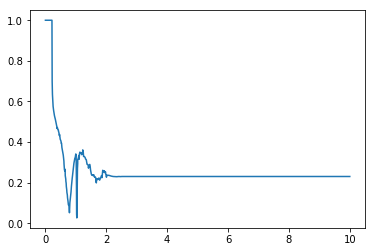

In [19]:
# fileName = input('Signal Rate filename: ')
fileName = 'testSignal.csv'
writeFile = photonSignalDataPath(fileName)
dataIn = pd.read_csv(writeFile, sep = ',')



plt.plot(xList, branchRatioInterp(xList))


print (sommerFile)